# Task 1 - Decision Tree Classifier

In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import mnist_loader
import pandas as pd
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [2]:
# get mnist data from source
# http://yann.lecun.com/exdb/mnist/
mnist_loader.init()
train_img, train_y, test_img, test_y = mnist_loader.load()

Download complete.
Save complete.


In [3]:
# loader returns flattened images, reshape into 28x28 images
train_img = np.reshape(train_img, (60000, 28, 28))
train_y = np.reshape(train_y, (60000, ))
test_img = np.reshape(test_img, (10000, 28, 28))
test_y = np.reshape(test_y, (10000, ))

# extract only 0 and 1 images and labels
valid_nums = (train_y == 0) | (train_y == 1)
train_img = train_img[valid_nums]
train_y = train_y[valid_nums]
valid_nums = (test_y == 0) | (test_y == 1)
test_img = test_img[valid_nums]
test_y = test_y[valid_nums]

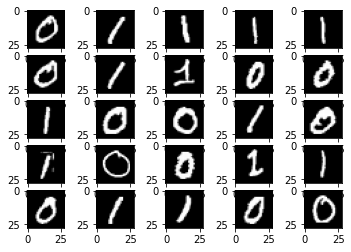

<Figure size 432x288 with 0 Axes>

In [4]:
# visualize some of the training examples
fig, ax = plt.subplots(5,5)
for i in range(0, 5):
	for j in range(0, 5):
		ax[i][j].imshow(train_img[5*i+j], cmap='gray')
plt.show()
plt.clf()

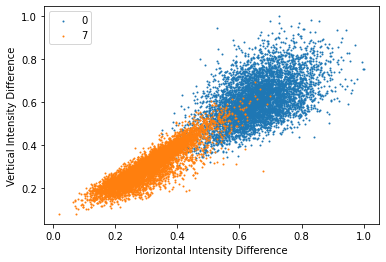

<Figure size 432x288 with 0 Axes>

In [5]:
# extract features from images
# feature1: Horizontal Intensity Difference
# feature2: Vertical Intensity Difference
train_X = np.zeros((train_img.shape[0], 2))
test_X = np.zeros((test_img.shape[0], 2))
for i, img in enumerate(train_img):
	train_X[i][0] = np.abs(np.mean(img[:, :14] - img[:, 14:]))
	train_X[i][1] = np.abs(np.mean(img[:14] - img[14:]))

for i, img in enumerate(test_img):
	test_X[i][0] = np.mean(img)
	test_X[i][1] = np.abs(np.mean(img[:14] - img[14:]))

# normalize features
train_X = train_X/np.max(train_X)
test_X = test_X/np.max(test_X)


# visualize both features to determine if there are any obvious groups
plt.scatter([train_X[i][0] for i in range(len(train_X)) if train_y[i] == 0], [train_X[i][1] for i in range(len(train_X)) if train_y[i] == 0], s = 1, label = '0')
plt.scatter([train_X[i][0] for i in range(len(train_X)) if train_y[i] == 1], [train_X[i][1] for i in range(len(train_X)) if train_y[i] == 1], s = 1, label = '7')
plt.xlabel('Horizontal Intensity Difference')
plt.ylabel('Vertical Intensity Difference')
plt.legend()
plt.show()
plt.clf()

In [14]:
# default parameters
base_clf = tree.DecisionTreeClassifier()
base_clf.fit(train_X, train_y)
print(f'Default Params: {100*base_clf.score(test_X, test_y):.4f}%')

# random split
clf = tree.DecisionTreeClassifier(splitter = 'random')
clf.fit(train_X, train_y)
print(f'Random Split:   {100*clf.score(test_X, test_y):.4f}%')

# entropy loss
clf = tree.DecisionTreeClassifier(criterion = 'entropy')
clf.fit(train_X, train_y)
print(f'Entropy Loss:   {100*clf.score(test_X, test_y):.4f}%')

Default Params: 89.2671%
Random Split:   89.5508%
Entropy Loss:   88.4634%


Using the default parameters (Gini impurity loss) results in slightly worse accuracy than random splits and higher accuracy than entropy loss.  It is worth noting that sometimes, the random split accuracy can be worse than the defualt parameter's accuracy - it is dependent on the random selection of the splits themselves.

# Task 2 - Bagging and Boosting

## Random Forest Classifier

In [28]:
rf_clf = RandomForestClassifier(n_estimators=10)
rf_clf.fit(train_X, train_y)
cv = RepeatedStratifiedKFold()
acc = 100*np.max(cross_val_score(rf_clf, test_X, test_y, scoring="accuracy", cv=cv))
print(f'Random Forest:  {acc:.4f}%')

Random Forest:  96.2175%


## Gradient Boost Classifier

In [26]:
gb_clf = GradientBoostingClassifier(n_estimators=10)
gb_clf.fit(train_X, train_y)
cv = RepeatedStratifiedKFold()
acc = 100*np.max(cross_val_score(gb_clf, test_X, test_y, scoring="accuracy", cv=cv))
print(f'Gradient Boost: {acc:.4f}%')

Gradient Boost: 97.1631%


Based on the test accuracy, the gradient boost classifier is able to more effectively classify the images when compared to both the random forest and base decision tree classifiers.  Using 5-fold cross validation also contributes to significantly higher test accuracy for both the random forest and gradient boost classifiers.

# Task 3 - Comparison

In [29]:
accs = []
pres = []
recs = []

# evaluate each modelwitg accuracy, precision, and recall (with cross validation)
for c in [base_clf, rf_clf, gb_clf]:
	accs.append(100*np.max(cross_val_score(c, test_X, test_y, scoring="accuracy", cv=cv)))
	pres.append(100*np.max(cross_val_score(c, test_X, test_y, scoring="precision", cv=cv)))
	recs.append(100*np.max(cross_val_score(c, test_X, test_y, scoring="recall", cv=cv)))

# foramt and print
scores = {'Accuracy': accs, 'Precision': pres, 'Recall': recs}
df = pd.DataFrame(data = scores, index = ['Decision Tree', 'Random Forest', 'Gradient Boost'])
print(df)

                 Accuracy  Precision     Recall
Decision Tree   94.799054  97.196262  96.916300
Random Forest   95.981087  99.069767  96.475771
Gradient Boost  96.926714  99.074074  96.916300


The metric that is being used for primary comparison is accuracy.  The ultimate goal of the classifiers is to conduct a binary classification, and accuracy makes the most sense out of any other metrics - using the accuracy to compare models is much more intuitive and useful than using another metric such as recall.

The table above shows that the gradient boost classifier is about 1.5% more accurate than base decision tree model: with gradient boost, the model misclassifies one out of every 32 images, while the base decision tree model misclassifies one out of every 19 images.  That being said, the recall for both models is identical, so we have one metric that suggests that gradient boost is better and one that suggests that it is worse.

With regard to this classification problem, accuracy is a preff